# Домашнее задание 7

Это домашнее задание по материалам второго семинаров. Дедлайн по отправке - 23:55 7 апреля. 

Домашнее задание выполняется в этом же Jupyter Notebook'e и присылается мне на почту: __beznosikov.an@phystech.edu__.

Решение каждой задачи необходимо поместить после её условия.

Файл должен называться: Фамилия_Имя_Optimization_HW_7

При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться без ошибок. 

## Задача 1

Рассмотрим "распределенную" задачу минимизации:
\begin{equation}
\min_{x \in \mathbb{R}^d} f(x) = \frac{1}{n} \sum\limits_{i=1}^n f_i(x) = \frac{1}{2n} \sum\limits_{i=1}^n x^T A_i x - b^T_i x,
\end{equation}
где $n = 10$, в качестве матриц $\{A_i\}_{i=1}^n$ - случайные матрицы с $L =1000$, $\mu = 1$, $d = 100$, $\{b_i\}_{i=1}^n$ - так же случайные векторы.

__(а)__ Для такой задачи симулируем распределенное решение (вычисления на 1 компьютере, без распараллеливания). 
Реализуйте обычный распределенный градиентый спуск с операторами сжатия. Сжимайте информацию только от устройств к серверу. Используйте операторы сжатия $\text{Rand}1\%$, $\text{Rand}5\%$, $\text{Rand}10\%$, $\text{Rand}20\%$. Для каждого случая подберите шаг $\gamma$ для наилучшей сходимости, постройте сравнительный график сходимости (по оси $y$ - критерий $\| \nabla f(x^k)\|^2$, а по оси $x$ - число "переданной информации" от устройств к серверу). Сделайте вывод.

In [1]:
import numpy as np
from numpy import linalg
import sklearn 
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_svmlight_file
import math
import pandas as pd
from datetime import datetime
from scipy.spatial import distance
import re
import matplotlib.pyplot as plt
import scipy.stats as sts
from scipy.stats import ortho_group
m = ortho_group.rvs(dim=3)
from sklearn import ensemble, model_selection, metrics, tree
%matplotlib inline
from sklearn.datasets import load_digits
import time

In [2]:
d = 100
mu = 1
L = 1000
n = 10
E = np.eye(d)

def positive_determined_matrix(d, mu, L): #генерация положительно-определенной матрицы, так чтобы A-mu*I >= 0
    i = 0
    while i == 0:
        diagonal_entries = np.random.uniform(mu, L,d)
        diagonal_entries[0] = mu
        diagonal_entries[1] = L
        D = np.diag(diagonal_entries)
        m = ortho_group.rvs(d)
        A = m.dot(D).dot(np.linalg.inv(m))
        if (np.all(np.linalg.eigvals(A-mu*E) >= 0)):
            i += 1
    return A
mas_A = []
mas_b = []
for i in range(n):
    A1 = positive_determined_matrix(d, mu, L)
    b1 = np.random.uniform(-100, 100, d)
    mas_A.append(A1)
    mas_b.append(b1)

In [3]:
def gradient(x, A, b):
    return A@x - b

In [4]:
def rand_k(k):
    return np.random.choice(d, k, replace = True)

In [5]:
def distributed_gradient_descent_rand(A, b, start, lr, amount_of_iterations, k):
    x = start
    call = []
    criterion = []
    count = 0
    for j in range(amount_of_iterations):
        S = np.zeros(d)
        grad1 = np.zeros(d)
        a = rand_k(k)
        for i in range(n):
            grad = gradient(x, A[i], b[i])
            grad1 += grad
            S[a] += grad[a]
        criterion.append(1/n*np.linalg.norm(grad1)**2)
        count += n*k
        call.append(count)
        x = x - lr*S/n
    return x, call, criterion

In [6]:
res1, call1, grad1 = distributed_gradient_descent_rand(mas_A, mas_b, np.zeros(d), 1/(4*L*(1 + 2*d/(1*n))), 10000, 1)
res2, call2, grad2 = distributed_gradient_descent_rand(mas_A, mas_b, np.zeros(d), 1/(4*L*(1 + 2*d/(5*n))), 10000, 5)
res3, call3, grad3 = distributed_gradient_descent_rand(mas_A, mas_b, np.zeros(d), 1/(4*L*(1 + 2*d/(10*n))), 10000, 10)
res4, call4, grad4 = distributed_gradient_descent_rand(mas_A, mas_b, np.zeros(d), 1/(4*L*(1 + 2*d/(20*n))), 10000, 20)

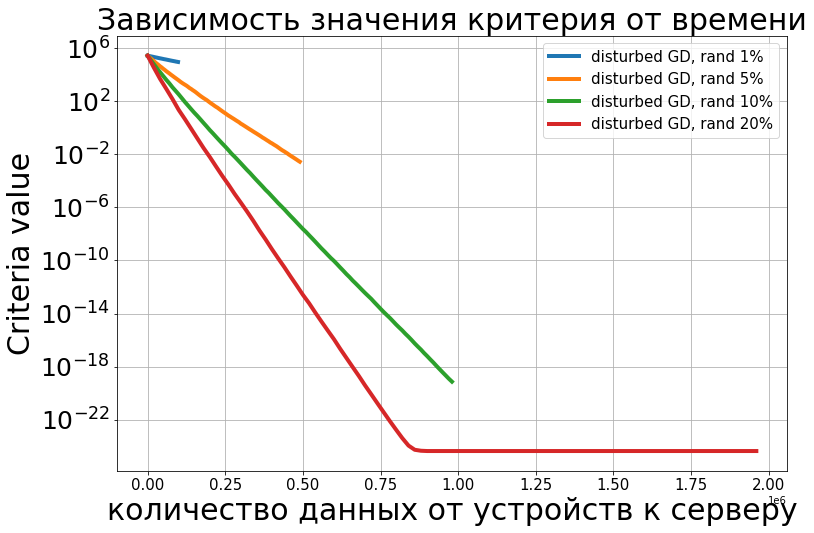

In [7]:
X1 = np.array([call1[100*i] for i in range(0, 99)])
Y1 = np.array([grad1[100*i] for i in range(0, 99)])

X2 = np.array([call2[100*i] for i in range(0, 99)])
Y2 = np.array([grad2[100*i] for i in range(0, 99)])

X3 = np.array([call3[100*i] for i in range(0, 99)])
Y3 = np.array([grad3[100*i] for i in range(0, 99)])

X4 = np.array([call4[100*i] for i in range(0, 99)])
Y4 = np.array([grad4[100*i] for i in range(0, 99)])
    
plt.figure(figsize=(12, 8))

plt.semilogy(X1, Y1, linewidth=4, label = 'disturbed GD, rand 1%')
plt.semilogy(X2, Y2, linewidth=4, label = 'disturbed GD, rand 5%')
plt.semilogy(X3, Y3, linewidth=4, label = 'disturbed GD, rand 10%')
plt.semilogy(X4, Y4, linewidth=4, label = 'disturbed GD, rand 20%')

plt.legend(loc="upper right", fontsize=15)
plt.xlabel(r"количество данных от устройств к серверу", fontsize=30)
plt.ylabel("Criteria value", fontsize=30)
plt.title(r"Зависимость значения критерия от времени", fontsize=30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=25)


plt.grid(True)

##### Метод сходится, графики построены для одинакового количества итераций. Видим, что при 20 процентах передаваемой на сервер информации метод сходится лучше и быстрее. Для каждого метода оптимальный шаг - $\gamma = \frac{1}{4L(1 + \frac{2d}{kn})}$ (получили на семинаре), где $k$ - количество рандомно выбираемых процентов иформации для передачи на сервер.

__(б)__ Теперь будем использовать в качестве операторов сжатия $\text{Top}10\%$. Сжимайте информацию только от устройств к серверу. Используйте два метода: обычный распределенный градиентный спуск с операторами сжатия, также распределенный градиентный спуск с техникой компесации ошибки (error feedback - смотри Алгоритм 1 из [статьи](https://arxiv.org/abs/2002.12410)). Для каждого метода подберите шаг $\gamma$ для наилучшей сходимости, постройте сравнительный график сходимости (по оси $y$ - критерий $\| \nabla f(x^k)\|^2$, а по оси $x$ - число итераций/коммуникаций). Сделайте вывод.

In [8]:
def distributed_gradient_descent_top(A, b, start, lr, amount_of_iterations, k):
    x = start
    criterion = []
    timeprog = []
    call = []
    count = 0
    for i in range (1, amount_of_iterations):
        S = np.zeros(d)
        grad1 = np.zeros(d)
        lr1 = 4/(mu*(i + 250*L*d/k/mu))
        for j in range (n): 
            a = np.argpartition(abs(gradient(x, A[j], b[j])), -k)[-k:]
            grad = gradient(x, A[j], b[j])
            S[a] += grad[a]
            grad1 += grad
        x = x - lr1*S/n
        count += k*n
        call.append(count)
        criterion.append(1/n*np.linalg.norm(grad1)**2)
    return x, call, criterion

In [9]:
res1, call1, grad1 = distributed_gradient_descent_top(mas_A, mas_b, np.zeros(d), 1/(4*L*(1 + 2*d/(10*n))), 10000, 10)

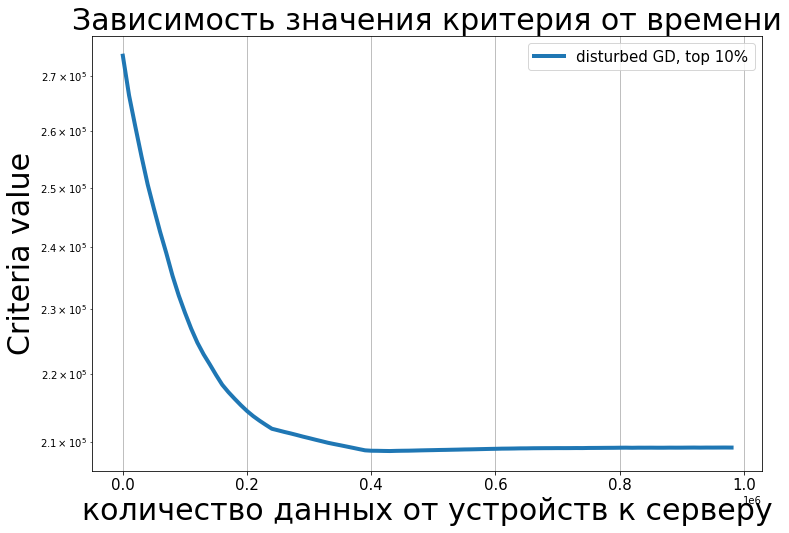

In [10]:
X1 = np.array([call1[100*i] for i in range(0, 99)])
Y1 = np.array([grad1[100*i] for i in range(0, 99)])
    
plt.figure(figsize=(12, 8))

plt.semilogy(X1, Y1, linewidth=4, label = 'disturbed GD, top 10%')

plt.legend(loc="upper right", fontsize=15)
plt.xlabel(r"количество данных от устройств к серверу", fontsize=30)
plt.ylabel("Criteria value", fontsize=30)
plt.title(r"Зависимость значения критерия от времени", fontsize=30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=25)


plt.grid(True)

In [11]:
def distributed_gradient_descent_top_error_feedback(A, b, start, lr, amount_of_iterations, k):
    x = start
    criterion = []
    timeprog = []
    call = []
    count = 0
    e = np.zeros((n, d))
    for i in range (1, amount_of_iterations):
        S = np.zeros(d)
        grad1 = np.zeros(d)
        lr1 = 4/(mu*(i + 250*L*d/k/mu))
        for j in range (n):
            a = np.argpartition(abs(gradient(x, A[j], b[j])*lr1 + e[j]), -k)[-k:]
            delta = np.zeros(d)
            grad = gradient(x, A[j], b[j])
            S[a] += (grad*lr1 + e[j])[a]
            delta[a] = (grad*lr1 + e[j])[a]
            e[j] = grad*lr1 + e[j] - delta
            grad1 += grad
        x = x - S/n
        count += k*n
        call.append(count)
        criterion.append(1/n*np.linalg.norm(grad1)**2)
    return x, call, criterion

In [12]:
res2, call2, grad2 = distributed_gradient_descent_top_error_feedback(mas_A, mas_b, np.zeros(d), 1, 10000, 10)

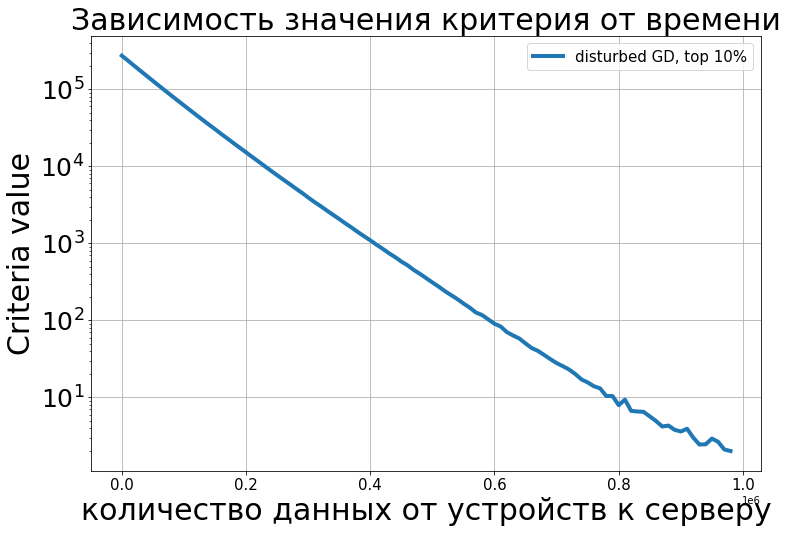

In [13]:
X1 = np.array([call2[100*i] for i in range(0, 99)])
Y1 = np.array([grad2[100*i] for i in range(0, 99)])
    
plt.figure(figsize=(12, 8))

plt.semilogy(X1, Y1, linewidth=4, label = 'disturbed GD, top 10%')

plt.legend(loc="upper right", fontsize=15)
plt.xlabel(r"количество данных от устройств к серверу", fontsize=30)
plt.ylabel("Criteria value", fontsize=30)
plt.title(r"Зависимость значения критерия от времени", fontsize=30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=25)


plt.grid(True)

##### Обыный top10 градиентный спуск не сходится, но алгоритм error feedback сходится гораздо лучше. Для сходимости error_feedback была выбрана $\gamma$, зависящая от номера итерации, а именно $\gamma = \frac{4}{\mu(i + \frac{250Ld}{k\mu})}$, где $i$ - номер итерации, $k$ - количество процентов иформации для передачи на сервер.

## Задача 2

Рассмотрим задачу логистической регрессии на датасете mushrooms с $\ell_2$-регуляризацией (коэффициент регуляризации равен $\frac{L}{1000}$). 

__(а)__ Симмулируем распределенное решение. Для этого разделите обучающую выборку случайно и равномерно на $n=10$ частей. Каждая такая часть сформирует $f_i$.

In [14]:
dataset = "mushrooms.txt"

In [15]:
from sklearn.datasets import load_svmlight_file

data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]
N, d = X.shape

y = 2*y - 3

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)
N_train, d_train = X_train.shape
N_test, d_test = X_test.shape
batch_size = N_train//n

In [17]:
indexes = np.random.randint(0, N_train, batch_size)
X_batch = X_train[indexes]
Y_batch = y_train[indexes]

In [18]:
L = 1/batch_size * 2 * max(np.linalg.eigvalsh((X_batch.T@X_batch + 2 * L/1000 * np.eye(d))))
print(f"L = {L}")
mu = 1/batch_size * 2  * min(np.linalg.eigvalsh((X_batch.T@X_batch + 2 * L/1000 * np.eye(d))))
print(f"mu = {mu}")

L = 20.593536106419993
mu = 0.00012692472176477432


In [19]:
indexes_mas = []
for i in range(n):
    indexes = np.random.randint(0, N_train, batch_size)
    indexes_mas.append(indexes)

In [20]:
def gradient(X, y, omega):
    return 2*(X.T@(X@omega - y))/n + L/500 * omega

In [21]:
def precisions(omega):
    number_of_true_precisions = 0
    for i in range (N_test): 
        if (omega.dot(X_test[i]) >= 0):
            k = 1
        else:
            k = -1
        if (k == y_test[i]):
            number_of_true_precisions = number_of_true_precisions + 1   
    procent_of_precisions = number_of_true_precisions/y_test.shape[0]
    return procent_of_precisions, number_of_true_precisions

__(б)__ Реализуйте симмуляцию (как в Задаче 1) обычного распределенного градиентного спуска с операторами сжатия, распределенного градиентного спуска с техникой error feedback, алгоритма DIANA (смотри Алгоритм 11 из [статьи](https://arxiv.org/abs/1905.11261)). Сжатия происходят только при пересылке от сервера к устройствам.

In [22]:
def regression_descent_rand(X, y, start, lr, amount_of_iterations, k, indexes_mas):
    omega = start
    call = []
    criterion = []
    count = 0
    precision = []
    for j in range(amount_of_iterations):
        S = np.zeros(d)
        grad1 = np.zeros(d)
        for i in range(n):
            a = rand_k(2*k)
            grad = gradient(X[indexes_mas[i]], y[indexes_mas[i]], omega)
            grad1 += grad
            S[a] += grad[a]
        omega = omega - lr*S/n
        criterion.append(1/n*np.linalg.norm(grad1)**2)
        count += n*k
        call.append(count)
        precision.append(precisions(omega))
    return call, criterion, precision

In [23]:
call1, grad1, precision1 = regression_descent_rand(X_train, y_train, np.zeros(d), 1/(4*L*(1 + 2*d/(10*n))) , 10000, 10, indexes_mas)

In [24]:
def regression_descent_top(X, y, start, lr, amount_of_iterations, k, indexes_mas):
    omega = start
    criterion = []
    timeprog = []
    call = []
    count = 0
    precision = []
    for i in range (1, amount_of_iterations):
        S = np.zeros(d)
        grad1 = np.zeros(d)
        lr1 = 4/(mu*(i + 250*L*d/k/mu))
        for j in range (n):
            a = np.argpartition(abs(gradient(X[indexes_mas[j]], y[indexes_mas[j]], omega)), -2*k)[-2*k:]
            grad = gradient(X[indexes_mas[j]], y[indexes_mas[j]], omega)
            S[a] += grad[a]
            grad1 += grad
        omega = omega - lr1*S/n
        count += k*n
        call.append(count)
        criterion.append(1/n*np.linalg.norm(grad1)**2)
        precision.append(precisions(omega))
    return call, criterion, precision

In [25]:
call2, grad2, precision2 = regression_descent_top(X_train, y_train, np.zeros(d), 1/(4*L*(1 + 2*d/(10*n))), 10000, 10, indexes_mas)

In [26]:
def regression_descent_rand_error_feedback(X, y, start, lr, amount_of_iterations, k, indexes_mas):
    omega = start
    criterion = []
    timeprog = []
    call = []
    precision = []
    count = 0
    e = np.zeros((n, d))
    for i in range (1, amount_of_iterations):
        S = np.zeros(d)
        grad1 = np.zeros(d)
        for j in range (n):
            a = np.random.choice(d, 2*k, replace = True)
            delta = np.zeros(d)
            grad = gradient(X[indexes_mas[j]], y[indexes_mas[j]], omega)
            S[a] += (grad*lr + e[j])[a]
            delta[a] = (grad*lr + e[j])[a]
            e[j] = grad*lr + e[j] - delta
            grad1 += grad
        omega = omega - S/n
        count += k*n
        call.append(count)
        criterion.append(1/n*np.linalg.norm(grad1)**2)
        precision.append(precisions(omega))
    return call, criterion, precision

In [27]:
call3, grad3, precision3 = regression_descent_rand_error_feedback(X_train, y_train, np.zeros(d), 1/(4*L*(1 + 2*d/(10*n))), 10000, 10, indexes_mas)

In [28]:
def regression_descent_top_error_feedback(X, y, start, lr, amount_of_iterations, k, indexes_mas):
    omega = start
    criterion = []
    timeprog = []
    call = []
    precision = []
    count = 0
    e = np.zeros((n, d))
    for i in range (1, amount_of_iterations):
        S = np.zeros(d)
        grad1 = np.zeros(d)
        lr1 = 4/(mu*(i + 250*L*d/k/mu))
        for j in range (n):
            delta = np.zeros(d)
            a = np.argpartition(abs(gradient(X[indexes_mas[j]], y[indexes_mas[j]], omega)*lr1 + e[j]), -2*k)[-2*k:]
            grad = gradient(X[indexes_mas[j]], y[indexes_mas[j]], omega)
            S[a] += (grad*lr1 + e[j])[a]
            delta[a] = (grad*lr1 + e[j])[a]
            e[j] = grad*lr1 + e[j] - delta
            grad1 += grad
        omega = omega - S/n
        count += k*n
        call.append(count)
        criterion.append(1/n*np.linalg.norm(grad1)**2)
        precision.append(precisions(omega))
    return call, criterion, precision

In [29]:
call4, grad4, precision4 = regression_descent_top_error_feedback(X_train, y_train, np.zeros(d), 1/(4*L*(1 + 2*d/(10*n))), 10000, 10, indexes_mas)

In [30]:
def regression_descent_rand_DIANA(X, y, start, lr, amount_of_iterations, k, indexes_mas, alpha):
    omega = start
    criterion = []
    timeprog = []
    call = []
    precision = []
    count = 0
    h = np.array([gradient(X[indexes_mas[0]], y[indexes_mas[0]], omega)])
    for l in range (1, n):
        h = np.vstack([h, gradient(X[indexes_mas[l]], y[indexes_mas[l]], omega)])
    for i in range (1, amount_of_iterations):
        S = np.zeros(d)
        grad1 = np.zeros(d)
        for j in range (n):
            delta = np.zeros(d)
            a = np.random.choice(d, k, replace = True)
            grad = gradient(X[indexes_mas[j]], y[indexes_mas[j]], omega)
            S[a] += (grad - h[j])[a]
            delta[a] = (grad - h[j])[a]
            h[j] = h[j] + alpha*delta
            grad1 += grad
        omega = omega - lr/n*(S + sum(h[p] for p in range(n)))
        count += k*n
        call.append(count)
        criterion.append(1/n*np.linalg.norm(grad1)**2)
        precision.append(precisions(omega))
    return call, criterion, precision

In [31]:
call5, grad5, precision5 = regression_descent_rand_DIANA(X_train, y_train, np.zeros(d), 1/(L*(1 + 6*d/10*n)), 10000, 10, indexes_mas, 1/(d/10 + 1))

In [32]:
def regression_descent_top_DIANA(X, y, start, lr, amount_of_iterations, k, indexes_mas, alpha):
    omega = start
    criterion = []
    timeprog = []
    call = []
    precision = []
    count = 0
    h = np.array([gradient(X[indexes_mas[0]], y[indexes_mas[0]], omega)])
    for l in range (1, n):
        h = np.vstack([h, gradient(X[indexes_mas[l]], y[indexes_mas[l]], omega)])
    for i in range (1, amount_of_iterations):
        S = np.zeros(d)
        grad1 = np.zeros(d)
        lr1 = 4/(mu*(i + 250*L*d/k/mu))
        for j in range (n):
            delta = np.zeros(d)
            grad = gradient(X[indexes_mas[j]], y[indexes_mas[j]], omega)
            a = np.argpartition(abs(grad - h[j]), -2*k)[-2*k:]
            S[a] += (grad - h[j])[a]
            delta[a] = (grad - h[j])[a]
            h[j] = h[j] + alpha*delta
            grad1 += grad
        omega = omega - lr1/n*(S + sum(h[p] for p in range(n)))
        count += k*n
        call.append(count)
        criterion.append(1/n*np.linalg.norm(grad1)**2)
        precision.append(precisions(omega))
    return call, criterion, precision

In [33]:
call6, grad6, precision6 = regression_descent_top_DIANA(X_train, y_train, np.zeros(d), 1/(L*(1 + 6*d/(10*n))), 10000, 10, indexes_mas, 1/(d/10 + 1))

__(в)__ Используйте операторы сжатия $\text{Top}10\%$ и $\text{Rand}10\%$ во всех трех методах (всего получается 6 разных подходов). Для каждого подхода подберите шаг $\gamma$ для наилучшей сходимости, постройте 2 сравнительных графика сходимости (по оси $y$ - критерий $\| \nabla f(x^k)\|^2$ или точность предсказаний, а по оси $x$ - число итераций/коммуникаций). Сделайте вывод.

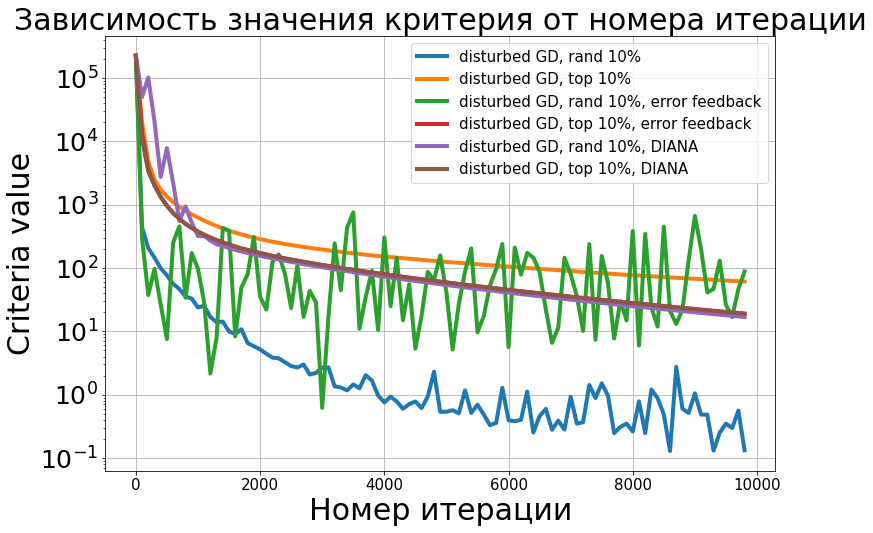

In [40]:
X1 = np.array([100*i for i in range(0, 99)])
Y1 = np.array([grad1[100*i] for i in range(0, 99)])

X2 = np.array([100*i for i in range(0, 99)])
Y2 = np.array([grad2[100*i] for i in range(0, 99)])

X3 = np.array([100*i for i in range(0, 99)])
Y3 = np.array([grad3[100*i] for i in range(0, 99)])

X4 = np.array([100*i for i in range(0, 99)])
Y4 = np.array([grad4[100*i] for i in range(0, 99)])

X5 = np.array([100*i for i in range(0, 99)])
Y5 = np.array([grad5[100*i] for i in range(0, 99)])

X6 = np.array([100*i for i in range(0, 99)])
Y6 = np.array([grad6[100*i] for i in range(0, 99)])


    
plt.figure(figsize=(12, 8))

plt.semilogy(X1, Y1, linewidth=4, label = 'disturbed GD, rand 10%')
plt.semilogy(X2, Y2, linewidth=4, label = 'disturbed GD, top 10%')
plt.semilogy(X3, Y3, linewidth=4, label = 'disturbed GD, rand 10%, error feedback')
plt.semilogy(X4, Y4, linewidth=4, label = 'disturbed GD, top 10%, error feedback')
plt.semilogy(X5, Y5, linewidth=4, label = 'disturbed GD, rand 10%, DIANA')
plt.semilogy(X6, Y6, linewidth=4, label = 'disturbed GD, top 10%, DIANA')

plt.legend(loc="upper right", fontsize=15)
plt.xlabel(r"Номер итерации", fontsize=30)
plt.ylabel("Criteria value", fontsize=30)
plt.title(r"Зависимость значения критерия от номера итерации", fontsize=30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=25)


plt.grid(True)

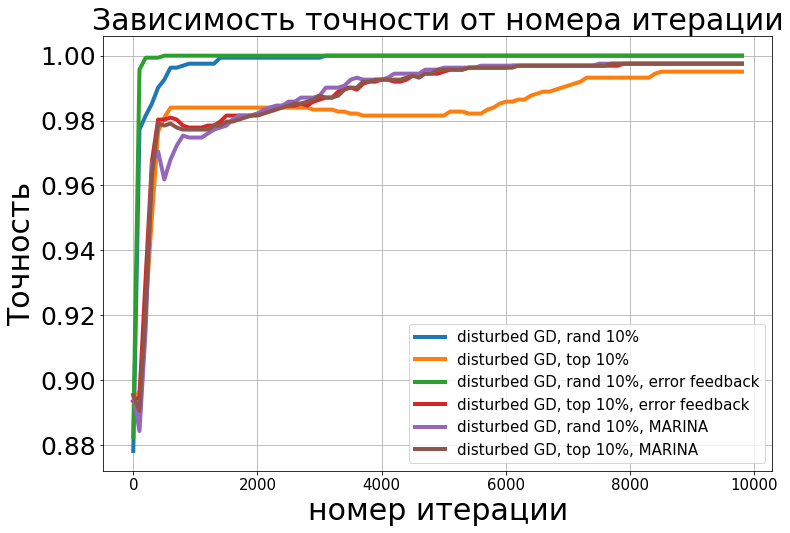

In [41]:
X1 = np.array([100*i for i in range(0, 99)])
Y1 = np.array([precision1[100*i][0] for i in range(0, 99)])

X2 = np.array([100*i for i in range(0, 99)])
Y2 = np.array([precision2[100*i][0] for i in range(0, 99)])

X3 = np.array([100*i for i in range(0, 99)])
Y3 = np.array([precision3[100*i][0] for i in range(0, 99)])

X4 = np.array([100*i for i in range(0, 99)])
Y4 = np.array([precision4[100*i][0] for i in range(0, 99)])

X5 = np.array([100*i for i in range(0, 99)])
Y5 = np.array([precision5[100*i][0] for i in range(0, 99)])

X6 = np.array([100*i for i in range(0, 99)])
Y6 = np.array([precision6[100*i][0] for i in range(0, 99)])


    
plt.figure(figsize=(12, 8))

plt.plot(X1, Y1, linewidth=4, label = 'disturbed GD, rand 10%')
plt.plot(X2, Y2, linewidth=4, label = 'disturbed GD, top 10%')
plt.plot(X3, Y3, linewidth=4, label = 'disturbed GD, rand 10%, error feedback')
plt.plot(X4, Y4, linewidth=4, label = 'disturbed GD, top 10%, error feedback')
plt.plot(X5, Y5, linewidth=4, label = 'disturbed GD, rand 10%, MARINA')
plt.plot(X6, Y6, linewidth=4, label = 'disturbed GD, top 10%, MARINA')

plt.legend(loc="best", fontsize=15)
plt.xlabel(r"номер итерации", fontsize=30)
plt.ylabel("Точность", fontsize=30)
plt.title(r"Зависимость точности от номера итерации", fontsize=30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=25)


plt.grid(True)

### Вывод:
Из графиков видим, что методы с оператором сжатия top10% сходятся хуже, чем с оператоом rand10%. Среди методов лучшую сходимость показыавет распределенный GD и DIANA. Касательно точности предсказаний все методы показали хороший результат, лучше и быстрее всех справились распределенный GD и error feedback с оператором rand10%.
Заметим, что шаг выбираем, как в задании 1, а для метода DIANA $\gamma = \frac{1}{L(1 + \frac{6d}{kn})}, \alpha = \frac{1}{\frac{d}{k} + 1}$

__Бонусные пункты__

__(г)__ Реализуйте два метода: [EF21](https://proceedings.neurips.cc/paper/2021/hash/231141b34c82aa95e48810a9d1b33a79-Abstract.html) и [MARINA](https://arxiv.org/abs/2102.07845). Добавьте их к сравнительному анализу из пункта (в) (здесь важно обратить внимание на особенности алгоритма MARINA и отразить это в анализе). Сделайте вывод. 

In [36]:
#ответ

__(д)__ Добавьте в лучшие 3 (на Ваш взгляд) метода (обычный GD с оператором сжатия, GD с EF, DIANA, EF21, MARINA) возможность сжимать и при передаче от сервера к устройству. Для сжатия используйте только $\text{Top}10\%$ и $\text{Rand}10\%$. Проведите серию экспериментов и ответьте на следующие пункты:

1) Если при сжатии на сервере используются $\text{Top}10\%$ нужно ли использовать технику компесации ошибки на сервере? Опишите, как добавляли еe в метод (лучший вариант - выписать алгоритм частично или целиком). 

2) Перебирая разные комбинации из операторов $\text{Top}10\%$ и $\text{Rand}10\%$ для сжатия на сервера и на устройствах, найдите лучшую конфигурацию операторов сжатия для каждого метода.

3) Какой метод и с каким операторами показал в итоге лучшие результаты? Использовался ли при этом дополнительный error feedback на сервере? 